In [35]:
import numpy as np
import pandas as pd
from apyori import apriori

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

In [12]:
# Read in data into a dataframe number of rows - 6358
file = 'soccer_player_embeddings_feature_no_labels.csv'
df = pd.read_csv('../../datasets/final_embeddings/{}'.format(file))
df.head(2)

,Unnamed: 0,player_positions,player_fifa_api_id,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,player_positions_general
0,0,CB,218353,0.378084,0.493866,-0.218586,-0.238711,-0.500447,0.219325,0.125196,-0.119898,-0.141964,0.142511,-0.056706,0.011622,0.019336,0.023303,DEF
1,1,LB,189615,-1.046989,-0.190204,1.120495,0.563388,-0.440816,-0.198932,0.338791,0.223150,0.041387,-0.025337,0.229595,0.055748,-0.099781,0.020387,DEF


In [13]:
# Convert each row's player_positions from a string to a list
def convert_to_list(position_str):
    position_ls = sorted(position_str.split(", "))
    return position_ls

df['player_positions_list'] = df['player_positions'].apply(lambda x: convert_to_list(x))

In [14]:
# Convert player_positions_list into list of list for ARM
records = []
for i in range(0, len(df)):
    records.append(df['player_positions_list'][i])

In [15]:
# Min support chosen as 0.004 because 27.6 (mean of value counts) /6358 --> ~0.0043
association_rules = apriori(records, min_support=0.0043, min_confidence=0.5, min_length=2)
association_results = list(association_rules)

In [16]:
for item in association_results:

    #second index of the inner list
    support = str(item[1])
    
    print("Frequent itemset: {}".format(list(item[0])))
    

Frequent itemset: ['CM', 'CDM']
Frequent itemset: ['ST', 'CF']
Frequent itemset: ['LB', 'LWB']
Frequent itemset: ['CAM', 'CM', 'CDM']
Frequent itemset: ['RM', 'CAM', 'LM']
Frequent itemset: ['CDM', 'CM', 'CB']
Frequent itemset: ['RM', 'CM', 'CDM']


In [271]:
support_ls = []
frequent_itemsets = []
antecedent_ls = []
consequent_ls = []
confidence_ls = []
lift_ls = []
final_freq_itemset = []

for item in association_results:
    #third index of the list located at 0th
    #of the third index of the inner list
    final_freq_itemset.append(list(item[0]))
    for stats in item[2]:
        support_ls.append(item[1])
        frequent_itemsets.append(list(item[0]))
        antecedent_ls.append(list(stats[0]))
        consequent_ls.append(list(stats[1]))
        confidence_ls.append(stats[2])
        lift_ls.append(stats[3])

In [18]:
d = {'freq_itemset': frequent_itemsets, 
     'antecedent': antecedent_ls,
     'consequent': consequent_ls, 
     'support': support_ls,
     'confidence': confidence_ls, 
     'lift': lift_ls}

arm_df = pd.DataFrame(data=d)
arm_df

,freq_itemset,antecedent,consequent,support,confidence,lift
0,"[CM, CDM]",[CDM],[CM],0.119534,0.692168,3.318855
1,"[CM, CDM]",[CM],[CDM],0.119534,0.573152,3.318855
2,"[ST, CF]",[CF],[ST],0.019031,0.528384,2.903602
3,"[LB, LWB]",[LWB],[LB],0.004718,0.681818,5.749337
4,"[CAM, CM, CDM]","[CAM, CDM]",[CM],0.017301,0.846154,4.057199
5,"[RM, CAM, LM]","[CAM, LM]",[RM],0.021076,0.529644,3.668277
6,"[RM, CAM, LM]","[RM, CAM]",[LM],0.021076,0.551440,3.869821
7,"[CDM, CM, CB]","[CM, CB]",[CDM],0.009122,0.805556,4.664592
8,"[RM, CM, CDM]","[RM, CDM]",[CM],0.005348,0.772727,3.705128


In [49]:
def kth_neighbour(k, X, metric='euclidean'):
    neigh = NearestNeighbors(n_neighbors=k, metric=metric)
    neigh.fit(X)
    dist, ind = neigh.kneighbors(X)
    distances = sorted([dist[i][k - 1] for i in range(len(dist))])

    return distances


def plot_kdist(dist, idx):
    plt.figure(figsize =(7, 5))
    plt.plot(dist)
    plt.axvline(x=idx, color='r', linestyle='dashed')
    plt.axhline(y=dist[idx], color='r', linestyle='dashed')
    plt.ylabel("k-distances (eps)")
    plt.grid(True)
    plt.show()
    
def find_eps(dist):
    sec_drv = np.diff(dist, 2)
    start, end = 100, -300
    idx = np.argmax(sec_drv[start:end]) + start
    eps = dist[idx]
#     print('start = {}, end = {}'.format(start, end))
    print('eps_idx = {}, eps = {}'.format(idx, eps))
    return idx, eps

def try_dbscan(samples, eps, min_pts, metric='euclidean'):
    # Based on graph above, use eps = 0.9
    db = DBSCAN(eps=eps, min_samples=min_pts, metric=metric).fit(samples)
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    db_labels = db.labels_

    n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    n_noise_ = list(db_labels).count(-1)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, db_labels))
    
    # Black removed and is used for noise instead.
    plt.figure(figsize =(5, 5)) 
    unique_labels = set(db_labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (db_labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    return db.labels_, n_clusters_

In [286]:
y = df['player_positions']
X = df.drop(columns=['Unnamed: 0', 'player_positions', 'player_fifa_api_id',
                     'player_positions_general', 'player_positions_list'])

labels = []
for l in y.values:
    if ',' in l:
        labels.extend(l.split(", "))
    else:
        labels.append(l)

labels, counts = np.unique(labels, return_counts=True)

eps_idx = 6043, eps = 0.8405484171913807


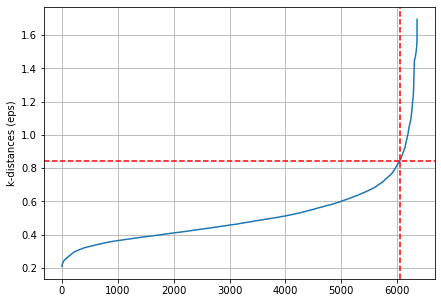

In [83]:
mp = len(X.columns) * 2
dist = kth_neighbour(mp, X)
idx, eps = find_eps(dist)
plot_kdist(dist, idx)

Estimated number of clusters: 16
Estimated number of noise points: 99
Silhouette Coefficient: 0.393


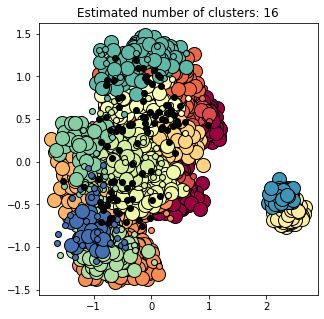

In [251]:
db_labels, n_clusters_ = try_dbscan(X, eps, mp)

In [254]:
# Convert each row's player_positions from a string to a list
def sort_pos_str(position_str):
    sorted_ls = sorted(position_str.split(", "))
    sorted_str = ', '.join(sorted_ls)
    return sorted_ls


def modify_positions(y, target):
    new_y = y.copy()
    new_grp = '_'.join(sorted(target))
    target_str = ', '.join(sorted(target))
    for i, row in enumerate(new_y):
        for pos in target:
            if pos in row:
                new_y[i].remove(pos)
                new_y[i].append(new_grp)
        
        new_y[i] = sorted(new_y[i])
        new_y[i] = ', '.join(new_y[i])
        
    
    return new_y

def get_labels(y):
    labels = []
    for l in y.values:
        if ',' in l:
            labels.extend(l.split(", "))
        else:
            labels.append(l)

    labels, counts = np.unique(labels, return_counts=True)
    for l, c in zip(labels, counts):
        print('Label: {}, Count: {}'.format(l, c))
    
    return labels
        
        
def labels_in_cluster(y, labels, given_cluster, num_clusters, title=None):
    y_train_vals = y.values
    classes_in_cluster = np.zeros(shape=(num_clusters, len(labels)), dtype=int)
    for i in range(num_clusters):
        dataInd = np.argwhere(given_cluster==i).flatten()
        for ind in dataInd:
            if ',' in y_train_vals[ind]:
                split = y_train_vals[ind].split(', ')
                for s in split:
                    j = np.where(labels == s)
                    classes_in_cluster[i][j] += 1
            else:
                j = np.where(labels == y_train_vals[ind])
                classes_in_cluster[i][j] += 1
    
    plt.figure(figsize=(15,5))
    if title:
        plt.title("Labels within clusters by {}".format(title))
    else:
        plt.title("Labels within clusters")
    sns.heatmap(classes_in_cluster, annot=True, cmap='Blues', fmt="d")
    plt.xticks([(i+0.5) for i in np.arange(len(labels))], labels=labels)
    plt.show()


In [291]:
arm_y = y.copy()

Target - ['CM', 'CDM']
Label: CAM, Count: 887
Label: CB, Count: 1326
Label: CDM_CM, Count: 2750
Label: CF, Count: 229
Label: GK, Count: 561
Label: LB, Count: 754
Label: LM, Count: 906
Label: LW, Count: 357
Label: LWB, Count: 44
Label: RB, Count: 779
Label: RM, Count: 918
Label: RW, Count: 390
Label: RWB, Count: 29
Label: ST, Count: 1157


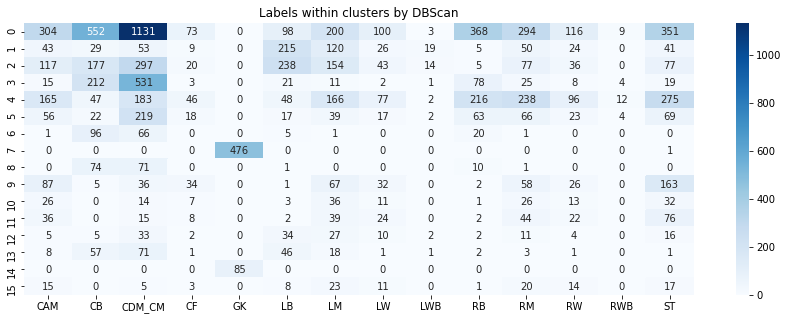

Target - ['ST', 'CF']
Label: CAM, Count: 887
Label: CB, Count: 1326
Label: CDM_CM, Count: 2750
Label: CF_ST, Count: 1386
Label: GK, Count: 561
Label: LB, Count: 754
Label: LM, Count: 906
Label: LW, Count: 357
Label: LWB, Count: 44
Label: RB, Count: 779
Label: RM, Count: 918
Label: RW, Count: 390
Label: RWB, Count: 29


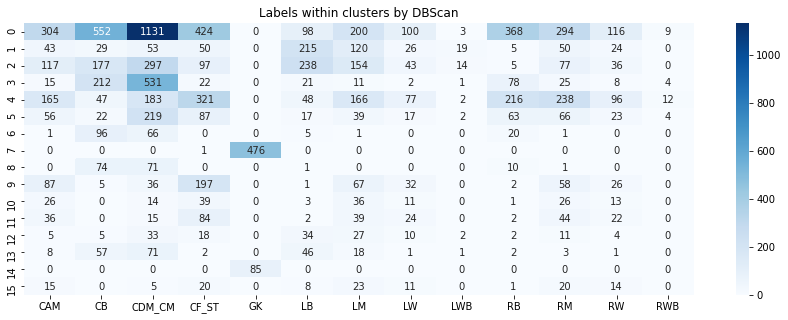

Target - ['LB', 'LWB']
Label: CAM, Count: 887
Label: CB, Count: 1326
Label: CDM_CM, Count: 2750
Label: CF_ST, Count: 1386
Label: GK, Count: 561
Label: LB_LWB, Count: 798
Label: LM, Count: 906
Label: LW, Count: 357
Label: RB, Count: 779
Label: RM, Count: 918
Label: RW, Count: 390
Label: RWB, Count: 29


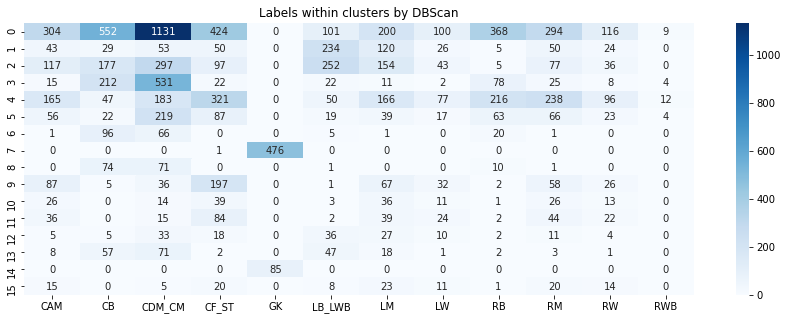

In [292]:
for target in final_freq_itemset[:3]:
#     target = arm_df['freq_itemset'][0]
    print('Target - {}'.format(target))
    arm_y = arm_y.apply(lambda x: sort_pos_str(x))
    arm_y = modify_positions(arm_y, target)
    new_labels = get_labels(arm_y)
    labels_in_cluster(arm_y, new_labels, db_labels, n_clusters_, title='DBScan')